<a href="https://colab.research.google.com/github/Caterinasacco/Semantic-Segmentation-/blob/main/Segmentaz_pareti_modello_Ci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Caricamento del dataset da kaggle


In [1]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"caterinasacco","key":"2e306986162f193005572f88b3bf7ac5"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d balraj98/facades-dataset


Dataset URL: https://www.kaggle.com/datasets/balraj98/facades-dataset
License(s): other
 98% 33.0M/33.5M [00:00<00:00, 48.4MB/s]
100% 33.5M/33.5M [00:00<00:00, 43.3MB/s]


In [ ]:
!unzip facades-dataset.zip -d /content/dataset


#Librerie

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

#Preprocessing immagini e split train e test

In [6]:
train_image = "/content/dataset/trainA"
train_mask = "/content/dataset/trainB"
test_image = "/content/dataset/testA"
test_mask = "/content/dataset/testB"


def preprocess_image(image):
    image = tf.image.resize(image, (160, 160))
    image = image / 255.0
    return image

def preprocess_mask(mask):
    mask = tf.image.resize(mask, (160, 160))
    mask = tf.image.rgb_to_grayscale(mask)  # Scala di grigi
    mask = tf.squeeze(mask, axis=-1)        # Rimuoviamo l'ultimo asse
    mask = tf.cast(mask // 25, tf.uint8)    # Normalizziamo
    mask = tf.expand_dims(mask, axis=-1)    # Aggiungiamo un asse per il canale
    return mask

train_images = tf.keras.utils.image_dataset_from_directory(
    train_image,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_image)

test_images = tf.keras.utils.image_dataset_from_directory(
    test_image,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_image)

train_masks = tf.keras.utils.image_dataset_from_directory(
    train_mask,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_mask)

test_masks = tf.keras.utils.image_dataset_from_directory(
    test_mask,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_mask)



# Allineamento delle forme
train_dataset = tf.data.Dataset.zip((train_images, train_masks))
test_dataset = tf.data.Dataset.zip((test_images, test_masks))

# Filtriamo le forme non corrispondenti
def filter_valid_shapes(image, mask):
    return tf.equal(tf.shape(image), tf.shape(mask))

train_dataset = train_dataset.filter(
    lambda img, mask: tf.reduce_all(tf.shape(img) == [160, 160, 3]) and tf.reduce_all(tf.shape(mask) == [160, 160, 1])
)
test_dataset = test_dataset.filter(
    lambda img, mask: tf.reduce_all(tf.shape(img) == [160, 160, 3]) and tf.reduce_all(tf.shape(mask) == [160, 160, 1])
)

# Shuffle, Batch, Repeat e Prefetch
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

for img, mask in train_dataset.take(1):
    print(f"Forma delle immagini: {img.shape}")
    print(f"Forma delle maschere: {mask.shape}")


Found 400 files.
Found 106 files.
Found 400 files.
Found 106 files.
Forma delle immagini: (32, 160, 160, 3)
Forma delle maschere: (32, 160, 160, 1)


#Data augmentation

In [ ]:
def data_augmentation(img, mask):
    # 1. Flip orizzontale
    img = tf.image.random_flip_left_right(img)
    mask = tf.image.random_flip_left_right(mask)

    # 2. Flip verticale
    img = tf.image.random_flip_up_down(img)
    mask = tf.image.random_flip_up_down(mask)

    # 3. Rotazione casuale
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)  # Angoli multipli di 90°
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    # 4. Zoom casuale
    crop_size = tf.random.uniform(
        shape=[],
        minval=120,  # Ritaglio minimo (120x120)
        maxval=160,  # Ritaglio massimo (160x160)
        dtype=tf.int32
    )
    img = tf.image.resize_with_crop_or_pad(img, crop_size, crop_size)
    mask = tf.image.resize_with_crop_or_pad(mask, crop_size, crop_size)

    img = tf.image.resize(img, (160, 160))
    mask = tf.image.resize(mask, (160, 160))

    # 5. Luminosità
    img = tf.image.random_brightness(img, max_delta=0.2)

    # 6. Clipping per garantire valori validi
    img = tf.clip_by_value(img, 0.0, 1.0)

    return img, mask


In [ ]:
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
for img, mask in train_dataset.take(1):
    img = img[0].numpy()
    mask = mask[0].numpy()
    break

# Visualizza l'immagine e la maschera
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine con Data Augmentation
axes[0].imshow(img)
axes[0].set_title('Immagine dopo Data Augmentation')
axes[0].axis('off')

# Mostra la maschera corrispondente
axes[1].imshow(mask.squeeze(), cmap='tab10')
axes[1].set_title('Maschera dopo Data Augmentation')
axes[1].axis('off')

plt.show()

#Addestramento modello
Il modello segue l'approccio Encoder-Bottleneck-Decoder, caratteristico della U-Net:

Encoder: Estrae caratteristiche a più livelli tramite convoluzioni e pooling.

Bottleneck: Cattura le caratteristiche globali dell'immagine in una rappresentazione compatta.

Decoder: Ricostruisce la maschera di segmentazione utilizzando upsampling e concatenazione con i livelli corrispondenti dell'encoder.

In [7]:
inputs = layers.Input(shape=(160, 160, 3))

# Encoder
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

# Bottleneck
b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b1)

# Decoder
u1 = layers.UpSampling2D((2, 2))(b1)
u1 = layers.Concatenate()([u1, c2])
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

u2 = layers.UpSampling2D((2, 2))(c3)
u2 = layers.Concatenate()([u2, c1])
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

outputs = layers.Conv2D(10, (1, 1), activation='softmax')(c4)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
]
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/200
     13/Unknown 73s 2s/step - accuracy: 0.2755 - loss: 2.2362   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.2815 - loss: 2.2302 - val_accuracy: 0.4096 - val_loss: 1.9491 - learning_rate: 1.0000e-04
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 441ms/step - accuracy: 0.4078 - loss: 1.8682 - val_accuracy: 0.4096 - val_loss: 1.7551 - learning_rate: 1.0000e-04
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.4158 - loss: 1.7615 - val_accuracy: 0.4159 - val_loss: 1.7235 - learning_rate: 1.0000e-04
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step - accuracy: 0.4182 - loss: 1.7286 - val_accuracy: 0.4206 - val_loss: 1.6840 - learning_rate: 1.0000e-04
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 0.4279 - loss: 1.6935 - val_accuracy: 0.4280 - val_loss: 1.6620 - learning_rate: 1.0000e-04
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step - accuracy: 0.4454 - loss: 1.6339 - val_accuracy: 0.3548 - val_loss: 1.7435 - learning_rate: 1.0000e-04
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.432

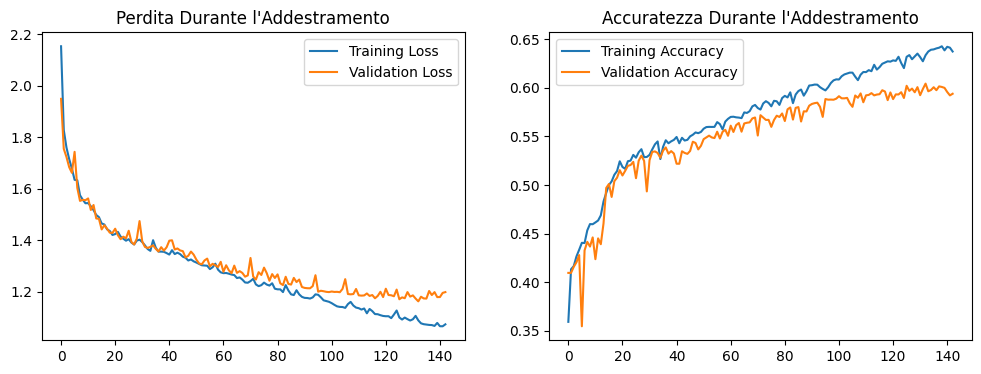

In [8]:
#Andamento loss e accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Perdita Durante l\'Addestramento')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuratezza Durante l\'Addestramento')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


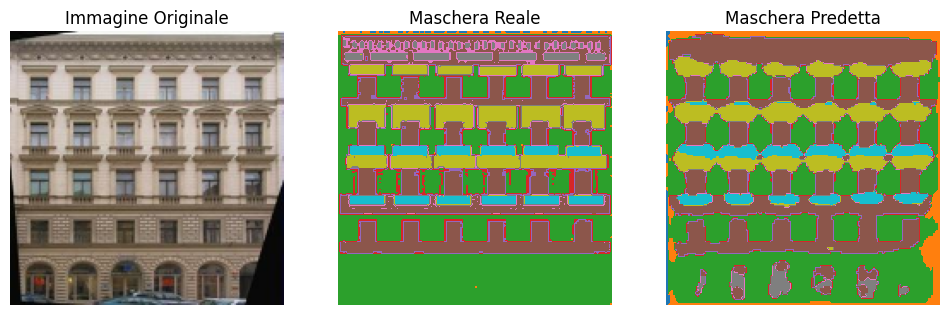

In [9]:
#predizioni
for img, mask in test_dataset.take(1):
    predictions = model.predict(img)
    pred_mask = tf.argmax(predictions, axis=-1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img[1].numpy())
    plt.title("Immagine Originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[1].numpy(), cmap='tab10')
    plt.title("Maschera Reale")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[1].numpy(), cmap='tab10')
    plt.title("Maschera Predetta")
    plt.axis("off")

    plt.show()


In [11]:
true_masks = []
pred_masks = []

# Itera su tutto il dataset di test
for img, mask in test_dataset:
    predictions = model.predict(img, verbose=0)
    pred_class = tf.argmax(predictions, axis=-1)

    true_masks.extend(mask.numpy().squeeze().flatten())  # Maschera reale
    pred_masks.extend(pred_class.numpy().flatten())  # Maschera predetta


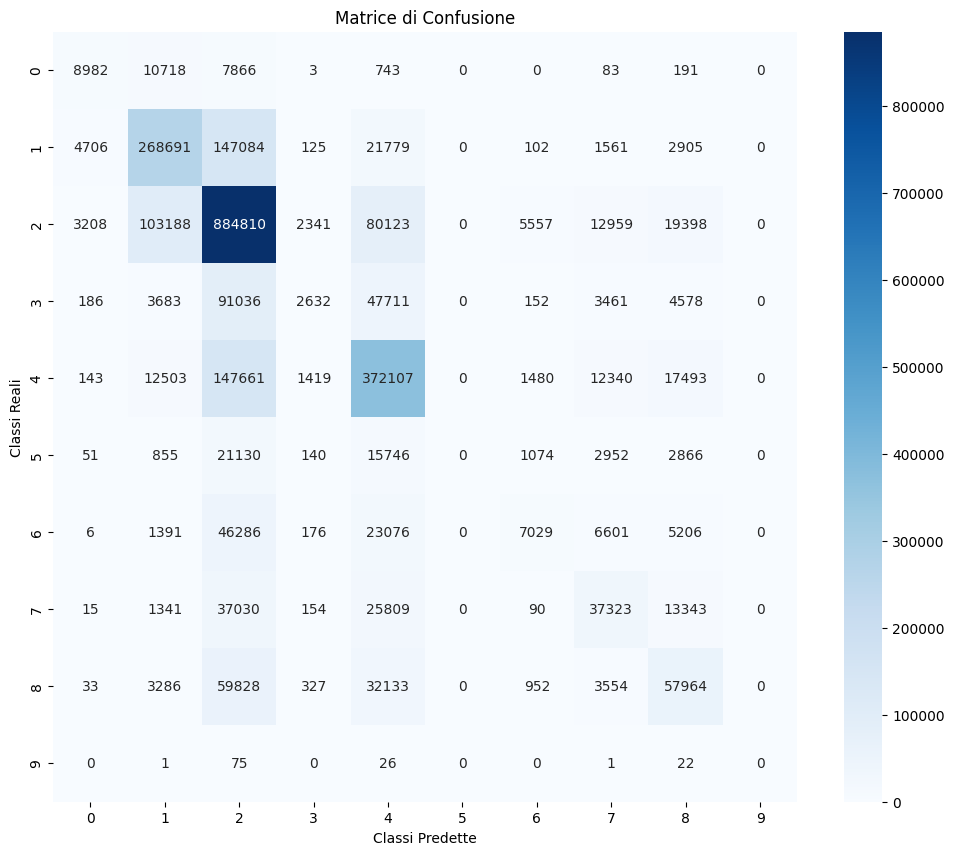

In [14]:
#Confusion matrix
num_classes = 10
conf_matrix = confusion_matrix(true_masks, pred_masks, labels=np.arange(num_classes))

# Visualizza la matrice di confusione
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Matrice di Confusione')
plt.xlabel('Classi Predette')
plt.ylabel('Classi Reali')
plt.show()
